In [1]:
#5ai) RMS-prop SGD OLS  

(array([0]), array([0]))
method MSE= 4.825343409939574e-06


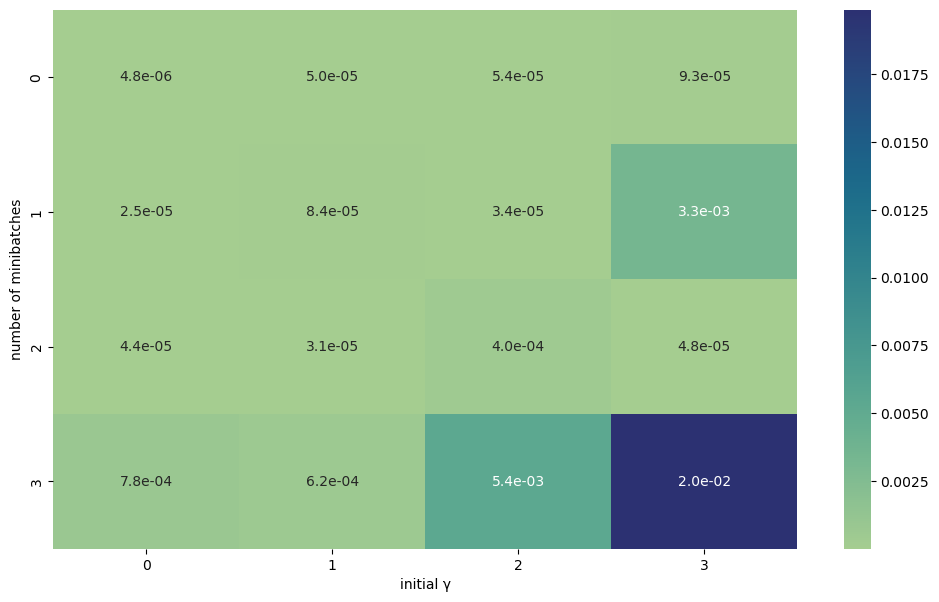

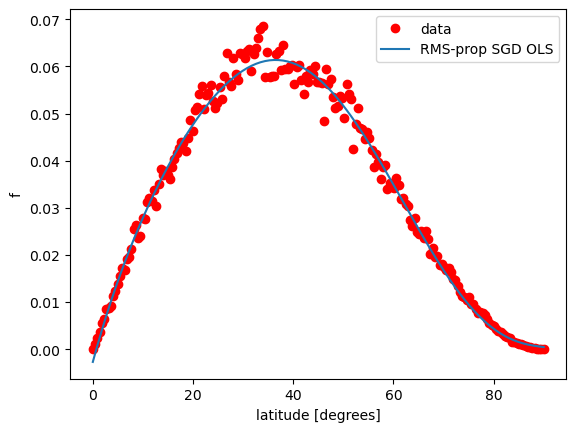

execution time= 4.1484832763671875e-05 s


In [2]:
# Importing various packages
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from math import exp, sqrt
from random import random, seed

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

#grid size
n = 200 

# Make data set.
x = np.linspace(0,(np.pi)/2,n).reshape(-1, 1)

#Northern H. parameters
s0 = 1
s2 = -0.473
a0 = 0.675
a2 = -0.192
i2 = -0.165

#flux function (eqn. (14) from Stone_1978)
y = 0.5*(s0*a2+s2*a0+(2/7)*s2*a2-i2)*((np.sin(x))**3-np.sin(x))

#noisy flux function
y_noisy = np.random.normal(y, abs(y*0.05)) 

#polynomial fit
degree=6
poly = PolynomialFeatures(degree=degree)
X = poly.fit_transform(x)

# Hessian matrix
H = (2.0/n)* X.T @ X
invH = np.linalg.pinv(H)

# Get the eigenvalues
EigValues, EigVectors = np.linalg.eig(H)

n_epochs = 10000

nsizes= 4
sizes=[1, 2, 4, 8]

ngammas = 4 
gammas = np.logspace(-3, -1, ngammas)

y_OLS_SGD_rms_array = np.zeros((nsizes, ngammas), dtype=object)
MSE_OLS_SGD_rms = np.zeros((nsizes, ngammas))
    
for s in range(nsizes):
    M=sizes[s] #we vary the size of the minibatches
    m = int(n/M) #number of minibatches
    
    for g in range(ngammas):
        gamma = gammas[g]

        beta_OLS = np.random.randn(degree+1,1)

        # Value for parameter rho
        rho = 0.99
        # Including AdaGrad parameter to avoid possible division by zero
        delta  = 1e-8

        for epoch in range(n_epochs):
            Giter = np.zeros(shape=(degree+1,degree+1))

            for i in range(m):
                random_index = M*np.random.randint(m)
                xi = X[random_index:random_index+M]
                yi = y_noisy[random_index:random_index+M]
                gradient_OLS = (2.0/M)* xi.T @ ((xi @ beta_OLS)-yi)
            # Previous value for the outer product of gradients
                Previous = Giter
            # Accumulated gradient
                Giter +=gradient_OLS @ gradient_OLS.T
            # Scaling with rho the new and the previous results
                Gnew = (rho*Previous+(1-rho)*Giter)
            # Taking the diagonal only and inverting
                Ginverse = np.c_[gamma/(delta+np.sqrt(np.diagonal(Gnew)))]
            # Hadamard product
                update = np.multiply(Ginverse,gradient_OLS)
                beta_OLS -= update

        y_OLS_SGD_rms = X @ beta_OLS
        
        y_OLS_SGD_rms_array[s, g] = y_OLS_SGD_rms

        MSE_OLS_SGD_rms[s, g] = MSE(y_OLS_SGD_rms, y_noisy)
        
#finding the minimum value of the MSE
MSE_OLS_SGD_rms_optimal = np.min(MSE_OLS_SGD_rms)
conditon = (MSE_OLS_SGD_rms == MSE_OLS_SGD_rms_optimal)
#the l, g for which we have the minimum MSE
result = np.where(conditon)
print(result)

print('method MSE=', MSE_OLS_SGD_rms_optimal)  

#saving the y that gives the optimal MSE
y_OLS_SGD_rms_optimal= y_OLS_SGD_rms_array[result]
y_OLS_SGD_rms_optimal=(y_OLS_SGD_rms_optimal[0])
        
import pandas as pd
import seaborn as sns

pd.DataFrame(MSE_OLS_SGD_rms)
mse_data_ols_sgd_rms = pd.DataFrame(MSE_OLS_SGD_rms)

plt.figure(figsize=(12,7))
sns.heatmap(data=mse_data_ols_sgd_rms, annot=True,  fmt=".1e", cmap="crest")
plt.xlabel("initial γ")
plt.ylabel("number of minibatches")
plt.show()

plt.figure()
plt.plot(x*180/np.pi, y_noisy, 'ro', label='data')
plt.plot(x*180/np.pi, y_OLS_SGD_rms_optimal, label='RMS-prop SGD OLS')
plt.xlabel('latitude [degrees]')
plt.ylabel('f')
plt.legend()
plt.show()

#Calculating the time processing time
import time
start_time = time.time()
print("execution time=", (time.time() - start_time), 's')

In [3]:
#5aii) RMS-prop SGD Ridge

(array([1]), array([2]))
method MSE= 1.0765210286654002e-05


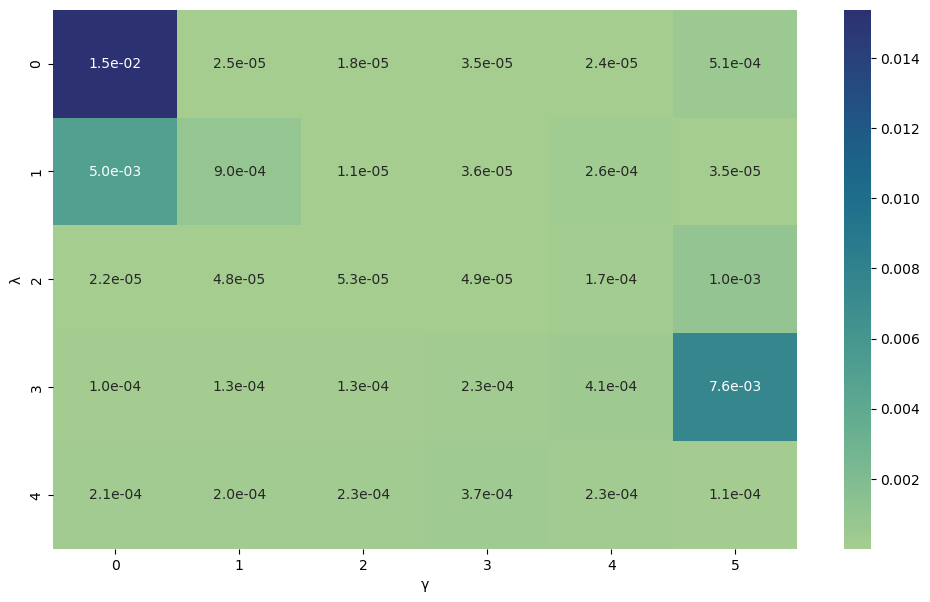

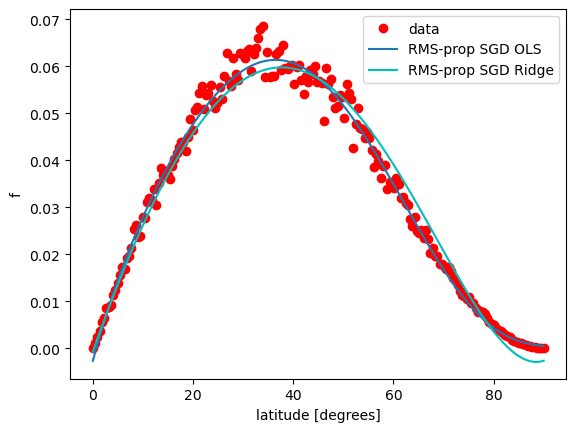

(array([0]), array([1]))
method MSE= 5.705189406135516e-06


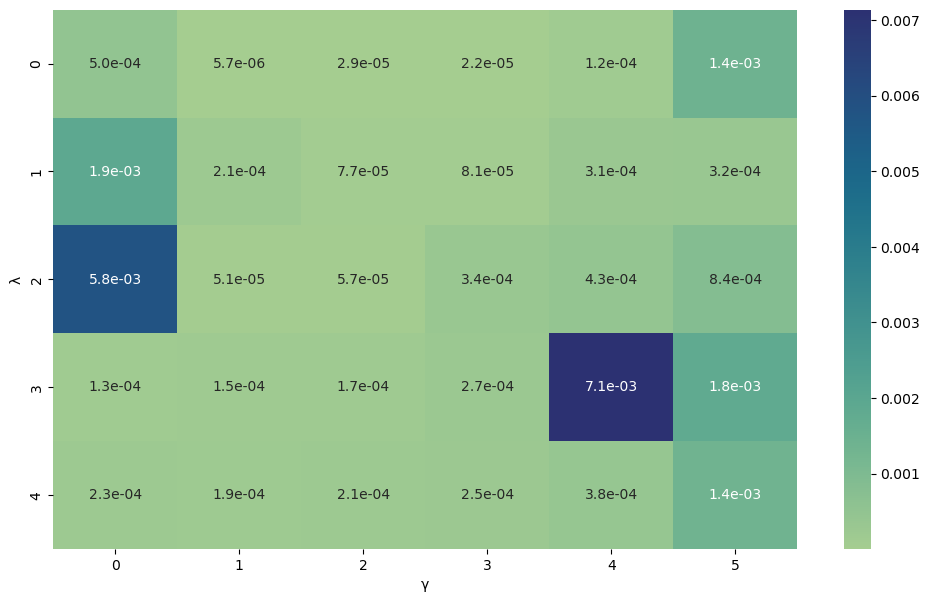

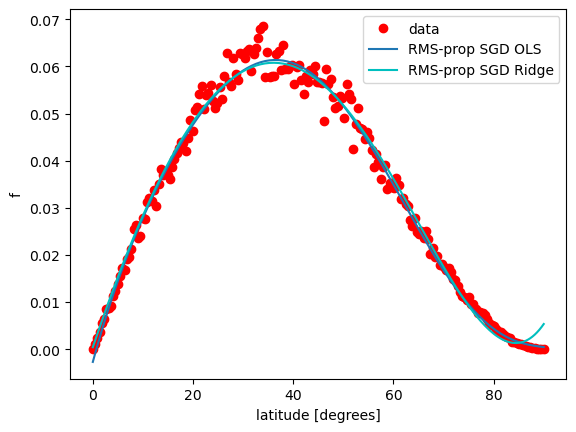

execution time= 5.125999450683594e-05 s


In [5]:
#Ridge parameter
nlambdas = 5 
lambdas = np.logspace(-5, -1, nlambdas)

ngammas = 6 
gammas = np.logspace(-3, -1, ngammas)

y_Ridge_SGD_rms_array = np.zeros((nlambdas, ngammas), dtype=object)
MSE_Ridge_SGD_rms = np.zeros((nlambdas, ngammas))

n_epochs = 1000

for M in [1, 2]:  
    m = int(n/M) #number of minibatches

    # Value for parameter rho
    rho = 0.9

    # Including AdaGrad parameter to avoid possible division by zero
    delta  = 1e-8

    for l in range(nlambdas):
        lmbda = lambdas[l]
        beta_Ridge = np.random.randn(degree+1,1)    

        # We vary the learning rate
        for g in range(ngammas):
            gamma=gammas[g]

            for epoch in range(n_epochs):
                Giter = np.zeros(shape=(degree+1,degree+1))    

                for i in range(m):
                    random_index = M*np.random.randint(m)
                    xi = X[random_index:random_index+M]
                    yi = y_noisy[random_index:random_index+M]

                    gradient_Ridge = (2.0/M)*xi.T @ (xi @ (beta_Ridge)-yi)+2*lmbda*beta_Ridge

                # Previous value for the outer product of gradients
                    Previous = Giter
                # Accumulated gradient
                    Giter +=gradient_Ridge @ gradient_Ridge.T
                # Scaling with rho the new and the previous results
                    Gnew = (rho*Previous+(1-rho)*Giter)
                # Taking the diagonal only and inverting
                    Ginverse = np.c_[gamma/(delta+np.sqrt(np.diagonal(Gnew)))]
                # Hadamard product
                    update = np.multiply(Ginverse,gradient_Ridge)
                    beta_Ridge -= update

            y_Ridge_SGD_rms = X @ beta_Ridge
            
            y_Ridge_SGD_rms_array[l, g] = y_Ridge_SGD_rms

            MSE_Ridge_SGD_rms[l, g]=MSE(y_noisy, y_Ridge_SGD_rms)    

    #finding the minimum value of the MSE
    MSE_Ridge_SGD_rms_optimal = np.min(MSE_Ridge_SGD_rms)
    conditon = (MSE_Ridge_SGD_rms == MSE_Ridge_SGD_rms_optimal)
    #the l, g for which we have the minimum MSE
    result = np.where(conditon)
    print(result)

    print('method MSE=', MSE_Ridge_SGD_rms_optimal)  

    #saving the y that gives the optimal MSE
    y_Ridge_SGD_rms_optimal= y_Ridge_SGD_rms_array[result]
    y_Ridge_SGD_rms_optimal=(y_Ridge_SGD_rms_optimal[0])

    pd.DataFrame(MSE_Ridge_SGD_rms)
    mse_data_ridge_rms = pd.DataFrame(MSE_Ridge_SGD_rms)

    plt.figure(figsize=(12,7))
    sns.heatmap(data=mse_data_ridge_rms, annot=True,  fmt=".1e", cmap="crest")
    plt.xlabel("γ")
    plt.ylabel("λ")
    plt.show()

    plt.figure()
    plt.plot(x*180/np.pi, y_noisy, 'ro', label='data')
    plt.plot(x*180/np.pi, y_OLS_SGD_rms_optimal, label='RMS-prop SGD OLS')
    plt.plot(x*180/np.pi, y_Ridge_SGD_rms_optimal, 'c-', label='RMS-prop SGD Ridge')
    plt.xlabel('latitude [degrees]')
    plt.ylabel('f')
    plt.legend()
    plt.show()
    
#Calculating the time processing time
import time
start_time = time.time()
print("execution time=", (time.time() - start_time), 's')